In [1]:
import numpy as np
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
from mil.data.datasets import mnist_bags

In [3]:
(bags_train, y_train, train_ins), (bags_test, y_test, test_ins) = mnist_bags.load()

In [4]:
# maximum  number of instances in the training set
max_len_train = np.max([len(bag) for bag in bags_train])
max_len_test = np.max([len(bag) for bag in bags_test])

max_ = np.max([max_len_train, max_len_test])
max_

16

In [5]:
bags_train_1D =[np.array(bag).reshape(-1, 28*28) for bag in bags_train]
bags_test_1D =[np.array(bag).reshape(-1, 28*28) for bag in bags_test]

# Train DeepAttentionMIL

In [6]:
from mil.metrics import AUC, BinaryAccuracy
from mil.validators import KFold
from mil.trainer.trainer import Trainer
from mil.models import SVC
from mil.bag_representation.mapping import DiscriminativeMapping
from mil.preprocessing import StandarizerBagsList, NormalizeBagsImage

from mil.models.bag_level.deep_attention import AttentionDeepPoolingMil
from mil.utils.utils import get_samples_weight
from mil.utils.padding import Padding

In [7]:
trainer = Trainer()

metrics = [AUC, BinaryAccuracy]
model = AttentionDeepPoolingMil(gated=False, threshold=0.4)
pipeline = [('padding', Padding(max_len=max_))]

trainer.prepare(model, preprocess_pipeline=pipeline ,metrics=metrics)

In [8]:
valid = KFold(n_splits=10, shuffle=True)

history = trainer.fit(bags_train, y_train, validation_strategy=valid, sample_weights='balanced',
                      verbose=1, model__epochs=10, model__batch_size=4, model__verbose=0)

10/10 [==============================] - 21s 2s/step - train_auc: 1.0000 - train_binaryaccuracy: 0.9994 - val_auc: 0.9577 - val_binaryaccuracy: 0.9250


In [9]:
print(np.mean([e['binaryaccuracy'] for e in history['metrics_val']]))
print(np.mean([e['auc'] for e in history['metrics_val']]))
history['metrics_val']

0.9178869
0.95502806


[{'auc': 0.93229175, 'binaryaccuracy': 0.9},
 {'auc': 0.97005206, 'binaryaccuracy': 0.95},
 {'auc': 0.96357226, 'binaryaccuracy': 0.93333334},
 {'auc': 0.971, 'binaryaccuracy': 0.92499995},
 {'auc': 0.9466146, 'binaryaccuracy': 0.9},
 {'auc': 0.9540924, 'binaryaccuracy': 0.9083333},
 {'auc': 0.9575898, 'binaryaccuracy': 0.91428566},
 {'auc': 0.94512504, 'binaryaccuracy': 0.90624994},
 {'auc': 0.9522058, 'binaryaccuracy': 0.9166667},
 {'auc': 0.95773655, 'binaryaccuracy': 0.925}]

In [10]:
trainer.predict_metrics(bags_test, y_test)

{'auc': 0.94952387, 'binaryaccuracy': 0.89}

In [11]:
# positive instances with more than 0.4 in attention weight
pos = trainer.get_positive_instances(bags_test)

In [12]:
# getting the attention weights for each bag
_, att = trainer.model.model(trainer.pipeline[:-1].transform(bags_test))
att = att.numpy().reshape([len(bags_test), -1])

# getting the prediction of the bag
y_pred = trainer.predict(bags_test)
y_pred = y_pred.reshape([len(bags_test), -1])
y_pred = np.where(y_pred >= 0.5, 1, 0).reshape(-1)

### Ploting attention weights

In [13]:
import matplotlib.pyplot as plt

def add_subplot_border(ax, width=4, color=None):
    fig = ax.get_figure()
    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle(
        (x0, y0), x1-x0, y1-y0,
        color=color,
        transform=ax.transAxes,
        zorder=-1,
        lw=2*width+1,
        fill=None,
    )
    fig.patches.append(rect)

def plot_bag(bag, label_bag, label_prediction, label_instance, attention, threshold, digit):
    fig, ax = plt.subplots(1,len(bag),figsize=(20,2.5))
    for i in range(len(bag)):
        #plotting images
        ax[i].axis('off')
        if label_instance[i] in digit and label_bag == 1:
            img_plot = ax[i].imshow(np.abs(bag[i]*255-255), cmap='gray', vmin=0, vmax=255)
        else:
            img_plot = ax[i].imshow(bag[i]*255, cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(str(label_instance[i]))
        ax[i].text(0.5,-0.15, str(round(attention[i], 3)), size=12, ha="center", 
         transform=ax[i].transAxes)
        
        # contour selected image
        if attention[i] > threshold and label_prediction==1:
            add_subplot_border(ax[i], color='r')
        
    
    fig.suptitle("Bag label: {}, Bag prediction: {}".format(label_bag, label_prediction))
    plt.show()

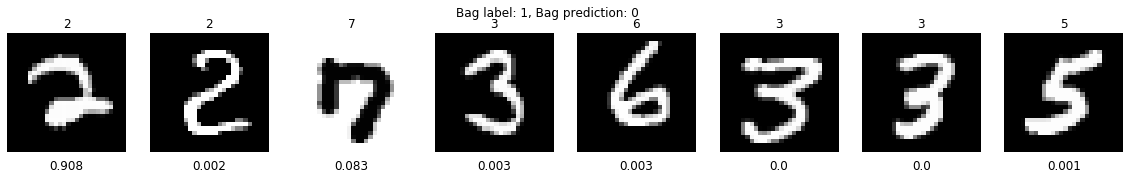

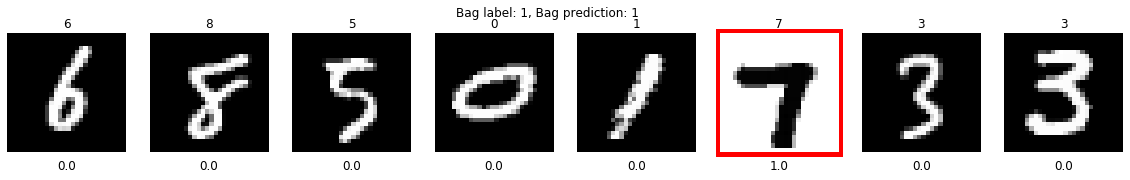

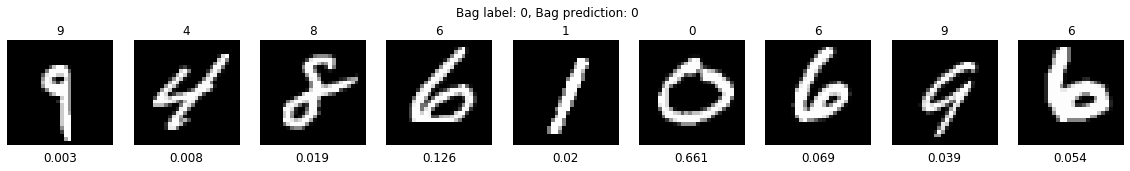

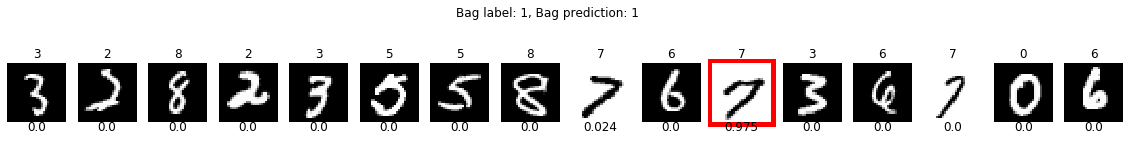

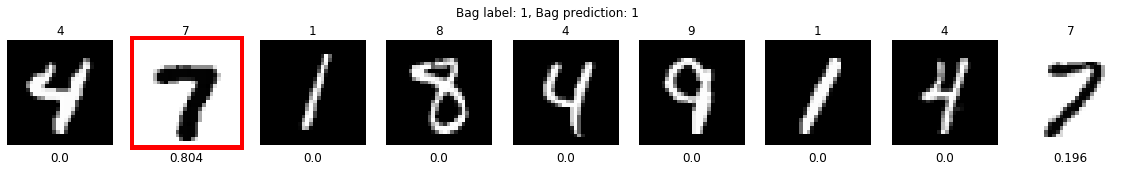

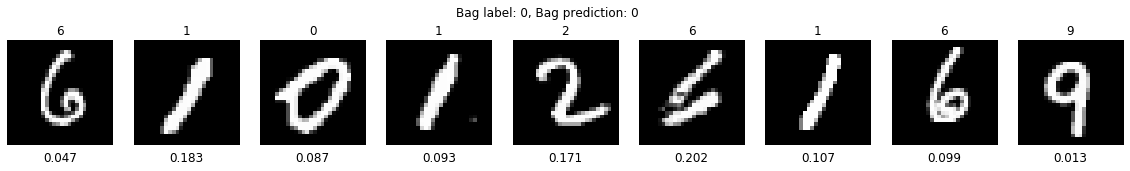

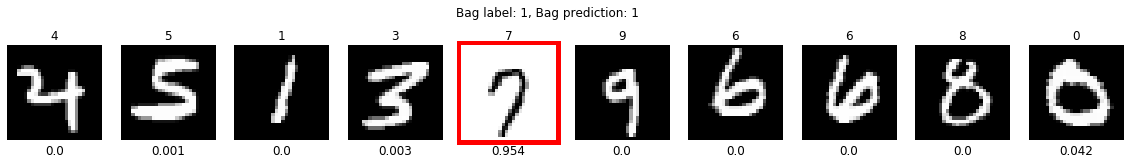

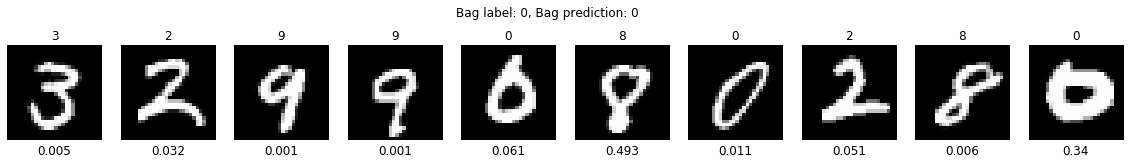

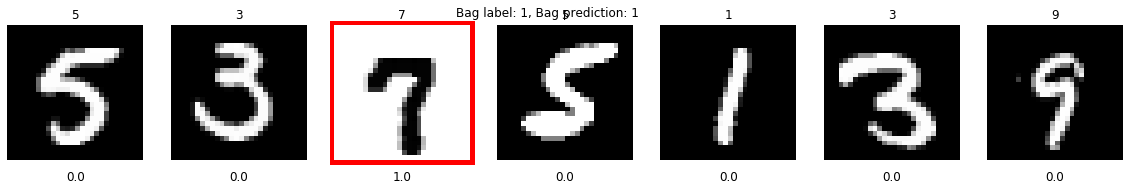

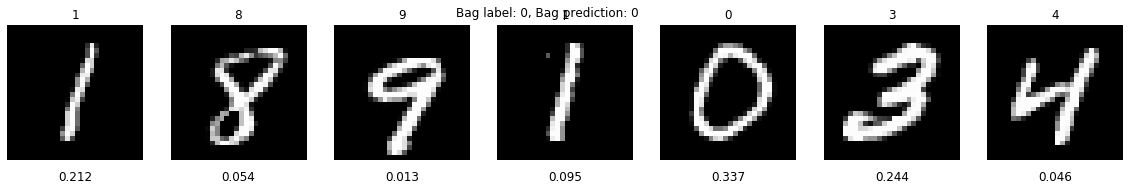

In [14]:
for i in range(10):
    plot_bag(bags_test[i], y_test[i], y_pred[i], test_ins[i], att[i], threshold=0.5, digit=[7])

In [15]:
true_label = []
for pos_ins in pos:
    true_label.append(test_ins[pos_ins[0]][pos_ins[1]])
y_pred = np.array(true_label)

# detected as positive instances
print(np.unique(y_pred, return_counts=True))

(array([0, 2, 3, 7, 8, 9], dtype=uint8), array([ 1,  2,  1, 64,  2,  2], dtype=int64))


# Train APR

In [16]:
from mil.models import APR

In [17]:
trainer = Trainer()

metrics = [AUC, BinaryAccuracy]
model = APR(thres=0.1, epsilon=0.38, step=200, verbose=0)
pipeline = []

trainer.prepare(model, preprocess_pipeline=pipeline ,metrics=metrics)

In [18]:
valid = KFold(n_splits=2, shuffle=True)

history = trainer.fit(bags_train_1D, y_train, validation_strategy=valid, verbose=1)

2/2 [==============================] - 5s 2s/step - train_auc: 0.7431 - train_binaryaccuracy: 0.8150 - val_auc: 0.5204 - val_binaryaccuracy: 0.5650


In [19]:
print(np.mean([e['binaryaccuracy'] for e in history['metrics_val']]))
history['metrics_val']

0.5575


[{'auc': 0.4965278, 'binaryaccuracy': 0.55},
 {'auc': 0.5203993, 'binaryaccuracy': 0.565}]

### Plotting the most discriminative features

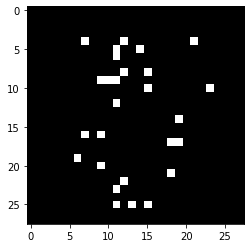

In [20]:
# most discriminative features
disc_features = trainer.model.rel_features_

test_im = np.zeros(shape=(28*28,))
test_im[disc_features] = 255
test_im = test_im.reshape(28,28)

plt.imshow(test_im, cmap='gray', vmin=0, vmax=255)
plt.show()

In [21]:
trainer.predict_metrics(bags_test_1D, y_test)

{'auc': 0.5714286, 'binaryaccuracy': 0.64}

In [22]:
# predicting positive instances
pos = trainer.get_positive_instances(bags_test_1D)

true_label = []
for pos_ins in pos:
    true_label.append(test_ins[pos_ins[0]][pos_ins[1]])
y_pred = np.array(true_label)

# detected as positive instances
print(np.unique(y_pred, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 1, 74,  1,  2,  6, 10,  2,  7,  8,  3], dtype=int64))


# Train MILES mapping

In [23]:
from mil.bag_representation.mapping import MILESMapping

In [24]:
trainer = Trainer()

metrics = [AUC, BinaryAccuracy]
model = SVC(kernel='linear', C=1, class_weight='balanced')
pipeline = [('disc_mapping', MILESMapping())]

trainer.prepare(model, preprocess_pipeline=pipeline ,metrics=metrics)

In [25]:
valid = KFold(n_splits=2, shuffle=True)

history = trainer.fit(bags_train_1D, y_train, validation_strategy=valid, verbose=1)

2/2 [==============================] - 35s 18s/step - train_auc: 1.0000 - train_binaryaccuracy: 1.0000 - val_auc: 0.7005 - val_binaryaccuracy: 0.7450


In [26]:
print(np.mean([e['binaryaccuracy'] for e in history['metrics_val']]))
history['metrics_val']

0.7575


[{'auc': 0.7439561, 'binaryaccuracy': 0.77},
 {'auc': 0.7005208, 'binaryaccuracy': 0.745}]